In [1]:
# Step 1: Clone repo and install packages
!git clone https://github.com/niaz1971/MALARIAL_CELL_CLASSIFICATION_USING_CNN.git
%cd MALARIAL_CELL_CLASSIFICATION_USING_CNN/
!pip install lime kaggle

Cloning into 'MALARIAL_CELL_CLASSIFICATION_USING_CNN'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 312 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (312/312), 4.21 MiB | 25.79 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/MALARIAL_CELL_CLASSIFICATION_USING_CNN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cbe2d6b60afac57b7a5c2e4f0209f2adcab393c1a300a0df13864dbd722d955c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
# Step 2: Set up Kaggle API for dataset download
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Step 3: Download and unzip malaria cell images dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 652M/675M [00:04<00:00, 220MB/s]
100% 675M/675M [00:04<00:00, 158MB/s]


In [4]:
# Step 4: Import required libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.image as mpimg

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Step 5: Prepare directory structure for train, valid, test splits
original_dataset = 'cell_images'
parasitized_dir = os.path.join(original_dataset, 'Parasitized')
uninfected_dir = os.path.join(original_dataset, 'Uninfected')

base_dir = 'malaria_data'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

classes = ['Parasitized', 'Uninfected']
for split_dir in [train_dir, valid_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [6]:
# Step 6: Function to split data into train, valid, test
def split_data(source_dir, train_dir, valid_dir, test_dir,
               train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total = len(files)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)

    train_files = files[:train_end]
    valid_files = files[train_end:valid_end]
    test_files = files[valid_end:]

    for fname in train_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(train_dir, fname))
    for fname in valid_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(valid_dir, fname))
    for fname in test_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(test_dir, fname))

# Split data for both classes
split_data(parasitized_dir,
           os.path.join(train_dir, 'Parasitized'),
           os.path.join(valid_dir, 'Parasitized'),
           os.path.join(test_dir, 'Parasitized'))

split_data(uninfected_dir,
           os.path.join(train_dir, 'Uninfected'),
           os.path.join(valid_dir, 'Uninfected'),
           os.path.join(test_dir, 'Uninfected'))

In [7]:
# Step 7: Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}
print("Class labels:", class_labels)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Class labels: {'Parasitized': 0, 'Uninfected': 1}


In [8]:
# Step 8: Build model with InceptionV3 base
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(4608, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1152, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 64,868,002 (247.45 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# Step 9: Compile model
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
# Step 10: Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('best_malaria_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=0.0001)
]

In [11]:
# Step 11: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6161 - loss: 0.8325
Epoch 1: val_loss improved from inf to 0.35156, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 689ms/step - accuracy: 0.6171 - loss: 0.8309 - val_accuracy: 0.8465 - val_loss: 0.3516 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7704 - loss: 0.5708
Epoch 2: val_loss improved from 0.35156 to 0.31632, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - accuracy: 0.7703 - loss: 0.5707 - val_accuracy: 0.8723 - val_loss: 0.3163 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7662 - loss: 0.5516
Epoch 3: val_loss improved from 0.31632 to 0.29302, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.7662 - loss: 0.5515 - val_accuracy: 0.8799 - val_loss: 0.2930 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━

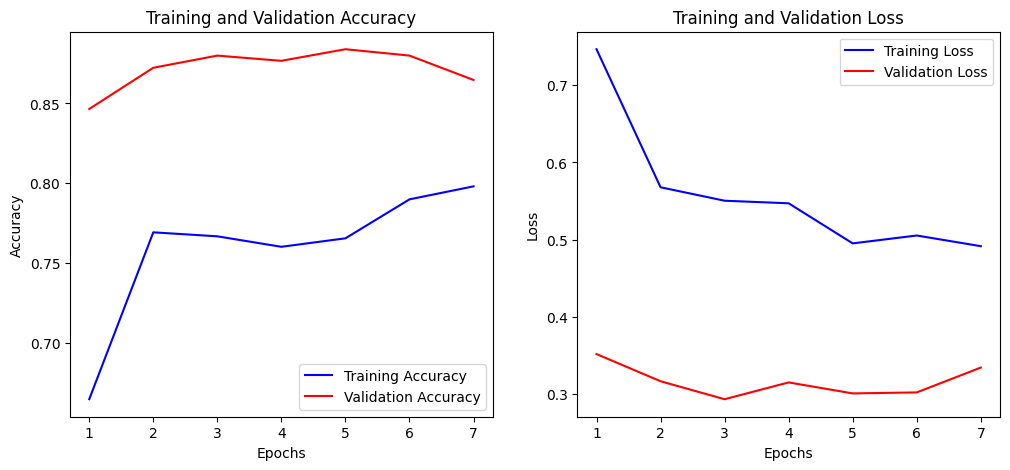

In [12]:
# Step 12: Plot training & validation accuracy and loss
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_curves(history)

In [13]:
# Step 13: Load best saved model
model = tf.keras.models.load_model('best_malaria_model.keras')

In [14]:
# Step 14: Evaluate on validation and test sets
val_loss, val_acc = model.evaluate(valid_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8812 - loss: 0.2933
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.8615 - loss: 0.2999
Validation Accuracy: 0.8799, Validation Loss: 0.2930
Test Accuracy: 0.8723, Test Loss: 0.3047


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step
              precision    recall  f1-score   support

 Parasitized       0.88      0.86      0.87      1378
  Uninfected       0.86      0.89      0.87      1378

    accuracy                           0.87      2756
   macro avg       0.87      0.87      0.87      2756
weighted avg       0.87      0.87      0.87      2756

Overall Test Accuracy: 0.8723


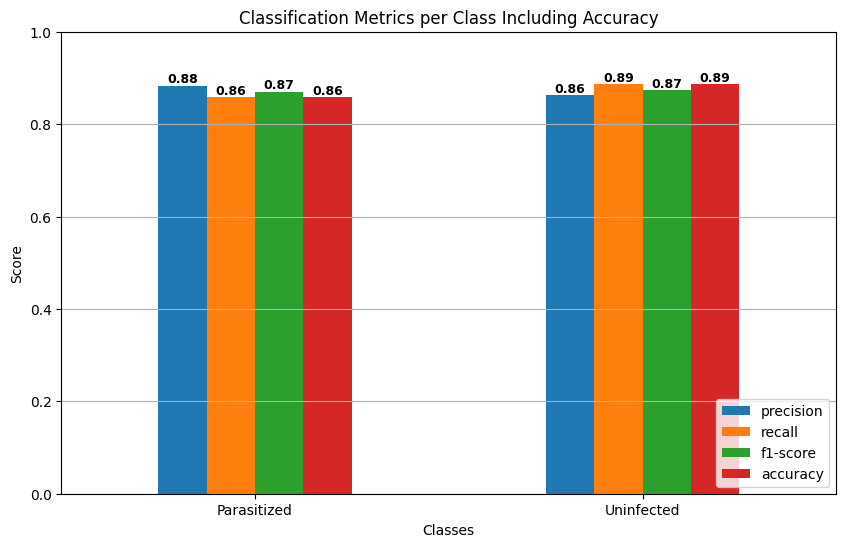


Overall Accuracy: 0.8723


In [15]:
# Step 15: Predictions and classification report on test set
nb_samples = len(test_generator.filenames)
preds = model.predict(test_generator, steps=nb_samples, verbose=1)
pred_labels = np.argmax(preds, axis=1)

print(classification_report(test_generator.classes, pred_labels,
                            target_names=[class_names[i] for i in range(2)]))

accuracy = accuracy_score(test_generator.classes, pred_labels)
print(f'Overall Test Accuracy: {accuracy:.4f}')

report_dict = classification_report(test_generator.classes, pred_labels,
                                    target_names=[class_names[i] for i in range(2)],
                                    output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_classes = report_df.iloc[:-3, :-1]

cm = confusion_matrix(test_generator.classes, pred_labels)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_names_list = [class_names[i] for i in range(len(class_accuracies))]
report_classes['accuracy'] = class_accuracies

ax = report_classes[['precision', 'recall', 'f1-score', 'accuracy']].plot(kind='bar', figsize=(10,6))
plt.title('Classification Metrics per Class Including Accuracy')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim([0,1])
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x()+p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

print(f"\nOverall Accuracy: {accuracy:.4f}")

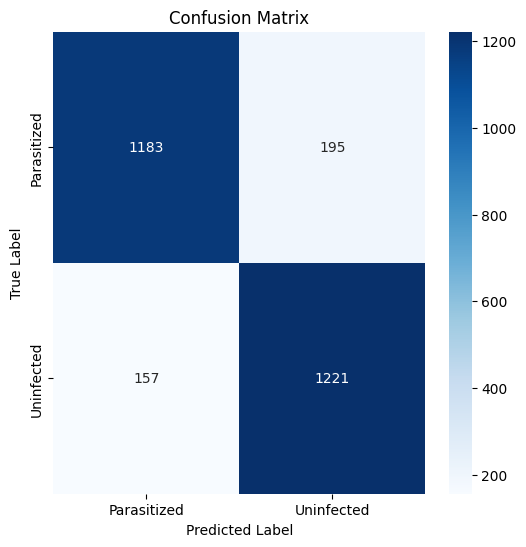

In [16]:
# Step 16: Confusion matrix plot
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names.values(),
            yticklabels=class_names.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

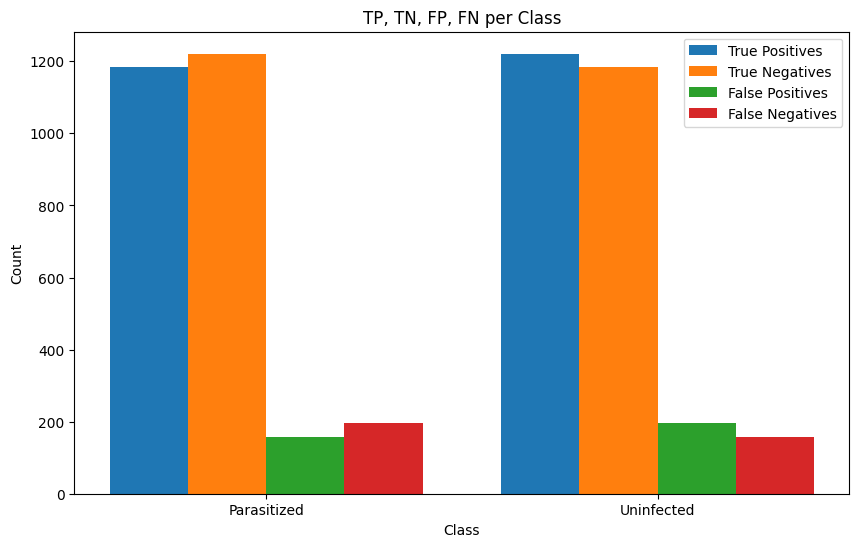

In [17]:
# Step 17: TP, TN, FP, FN calculation and plot
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, axis=0)
    temp = np.delete(temp, i, axis=1)
    TN.append(temp.sum())

x = np.arange(len(class_names))
width = 0.2
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 1.5*width, TP, width, label='True Positives')
rects2 = ax.bar(x - 0.5*width, TN, width, label='True Negatives')
rects3 = ax.bar(x + 0.5*width, FP, width, label='False Positives')
rects4 = ax.bar(x + 1.5*width, FN, width, label='False Negatives')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('TP, TN, FP, FN per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names.values())
ax.legend()
plt.show()

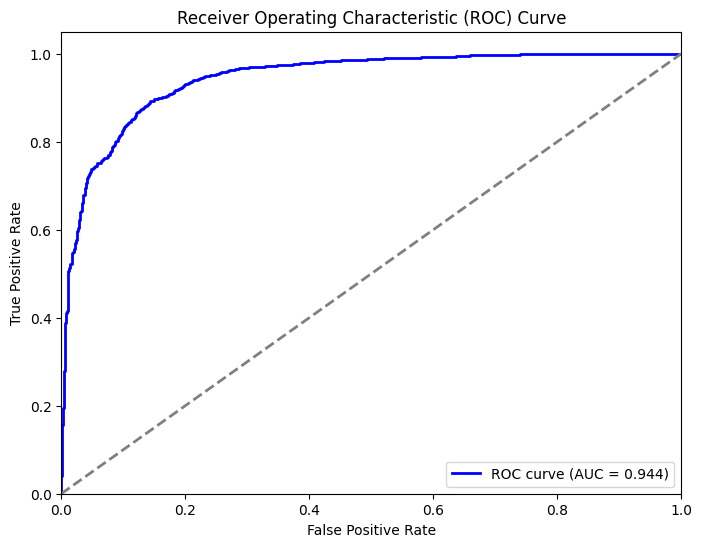

In [18]:
# Step 18: ROC Curve calculation and plot
fpr, tpr, thresholds = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='grey', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


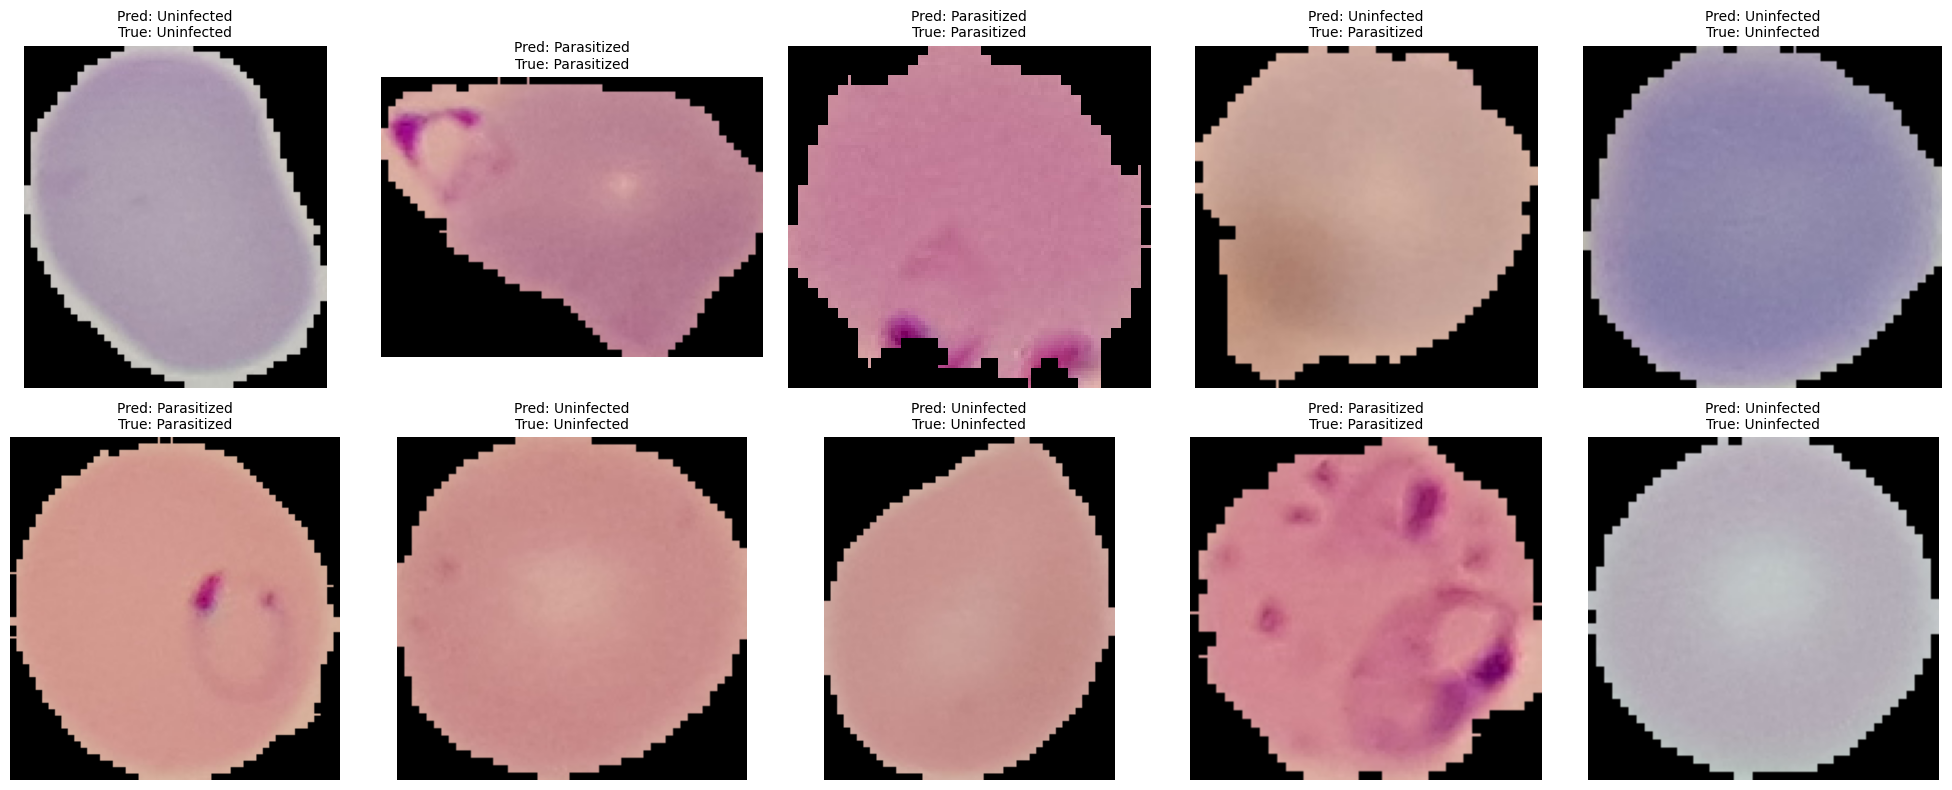

In [19]:
# Step 19: Visualize random test images with predictions
sample_files = random.sample(test_generator.filenames, 10)
plt.figure(figsize=(20,8))

for i, fname in enumerate(sample_files):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(test_dir, fname)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

    img_obj = load_img(img_path, target_size=(128,128))
    img_arr = img_to_array(img_obj) / 255.0
    img_exp = np.expand_dims(img_arr, axis=0)

    pred = model.predict(img_exp)
    pred_label = class_names[np.argmax(pred)]
    true_label = os.path.basename(os.path.dirname(img_path))

    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=10)

plt.tight_layout()
plt.show()